In [169]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from category_encoders import TargetEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import early_stopping
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

### Load data
- Obtenemos el dataset generado en notebook 01_DS_NS_features.ipynb

In [2]:
train_data = pd.read_parquet('data/train_data.parquet')  
test_data = pd.read_parquet('data/test_data.parquet')  

In [3]:
print('train_shape:', train_data.shape)
print('test_shape:', test_data.shape)

train_shape: (14063903, 32)
test_shape: (5936360, 32)


In [4]:
train_data.head()

fl_high  lag_rating  mov_avg_rating  movies_views  \
userId movieId                                                      
1      2              0         4.0             3.7           175   
       29             0         3.5             3.7           175   
       32             0         3.5             3.7           175   
       47             0         4.0             3.9           175   
       50             0         3.0             3.4           175   

                avg_user_rating  std_user_rating  median_user_rating  \
userId movieId                                                         
1      2               3.742857         0.382284                 4.0   
       29              3.742857         0.382284                 4.0   
       32              3.742857         0.382284                 4.0   
       47              3.742857         0.382284                 4.0   
       50              3.742857         0.382284                 4.0   

                antiguedad  year  Action  ...  Mystery  Romance  Sci-Fi  \
userId movieId                            ...                             
1      2               204  1995       0  ...        0        0       0   
       29              204  1995       0  ...        1        0       1   
       32              204  1995       0  ...        1        0       1   
       47              204  1995       0  ...        1        0       0   
       50              204  1995       0  ...        1        0       0   

                Thriller  War  Western  movies_pop  avg_movie_rating  \
userId movieId                                                         
1      2               0    0        0     17276.0          3.233329   
       29              0    0        0      6241.0          3.982214   
       32              1    0        0     34883.0          3.874394   
       47              1    0        0     31690.0          4.021205   
       50              1    0        0     33907.0          4.367476   

                std_movie_rating  median_movie_rating  
userId movieId                                         
1      2                0.960672                  3.0  
       29               0.981849                  4.0  
       32               0.891318                  4.0  
       47               0.911578                  4.0  
       50               0.769318                  4.5  

[5 rows x 32 columns]

### Balance Target

- Definimos el target de acuerdo al challenge
    * 1 in case the rating is >= 4 (flag for "high" rating) 
    * 0 in case the rating is < 4
    
- El dataset se encuentra balanceado por lo que no veo necesario de aplicar tecnicas de over-undes-smote sampling para tratar este problema.

In [5]:
target = 'fl_high'

In [103]:
td = train_data.groupby(['fl_high']).size().reset_index()
td['Percentage'] = 100 * td[0]  / td[0].sum()
print('balance del target en Train')
td

balance del target en Train


,fl_high,0,Percentage
0,0,6988030,49.6877
1,1,7075873,50.3123


In [104]:
td = test_data.groupby(['fl_high']).size().reset_index()
td['Percentage'] = 100 * td[0]  / td[0].sum()
print('balance del target en Test')
td

balance del target en Test


,fl_high,0,Percentage
0,0,3016823,50.819408
1,1,2919537,49.180592


### Prepare Model Data
- Dividimos las features del target en train y test.

In [8]:
target = 'fl_high'
X_train = train_data.drop(columns=[target], axis = 1)
y_train = train_data[target].values
X_test = test_data.drop(columns=[target], axis = 1)
y_test= test_data[target].values

In [9]:
X_train.head()

lag_rating  mov_avg_rating  movies_views  avg_user_rating  \
userId movieId                                                              
1      2               4.0             3.7           175         3.742857   
       29              3.5             3.7           175         3.742857   
       32              3.5             3.7           175         3.742857   
       47              4.0             3.9           175         3.742857   
       50              3.0             3.4           175         3.742857   

                std_user_rating  median_user_rating  antiguedad  year  Action  \
userId movieId                                                                  
1      2               0.382284                 4.0         204  1995       0   
       29              0.382284                 4.0         204  1995       0   
       32              0.382284                 4.0         204  1995       0   
       47              0.382284                 4.0         204  1995       0   
       50              0.382284                 4.0         204  1995       0   

                Adventure  ...  Mystery  Romance  Sci-Fi  Thriller  War  \
userId movieId             ...                                            
1      2                1  ...        0        0       0         0    0   
       29               1  ...        1        0       1         0    0   
       32               0  ...        1        0       1         1    0   
       47               0  ...        1        0       0         1    0   
       50               0  ...        1        0       0         1    0   

                Western  movies_pop  avg_movie_rating  std_movie_rating  \
userId movieId                                                            
1      2              0     17276.0          3.233329          0.960672   
       29             0      6241.0          3.982214          0.981849   
       32             0     34883.0          3.874394          0.891318   
       47             0     31690.0          4.021205          0.911578   
       50             0     33907.0          4.367476          0.769318   

                median_movie_rating  
userId movieId                       
1      2                        3.0  
       29                       4.0  
       32                       4.0  
       47                       4.0  
       50                       4.5  

[5 rows x 31 columns]

In [10]:
cat_cols = X_train.select_dtypes(exclude="number").columns
num_cols = X_train.select_dtypes(include="number").columns

### Pipeline
- Si bien el algoritmo seleccionado permite trabajar con datos categoricos y no ve afectado su rendmiento al no normalizar los datos. A fines del challenge genero un pipeline para mostrar la funcionalidad y ademas porque considero una buena practica preparar los datos para otros modelos que requieran standarizado y no permitan variables categoricas.

In [44]:
categorical_pipeline = Pipeline(
    steps=[
        ('Target encoding', TargetEncoder())
    ]
)

numeric_pipeline = Pipeline(
    steps=[#("impute", SimpleImputer(strategy="mean")), 
           ("scale", StandardScaler())]
)

full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

In [53]:
X_train_proc = full_processor.fit_transform(X_train, y_train)
X_test_proc = full_processor.transform(X_test)

### LightGBM
- Utilizo el modelo basado en el aumento del gradiente que tiene una gran velocidad de entrenamiento considerando el volumen del dataset de Movielens. Basa su crecimiento de árboles en forma de hojas en vez de niveles, es lo hace rapido pero logrando arboles de alta complejidad, sin embargo corremos el riesgo de overfitting el cual se prevee ajustando algunos de sus hipeparámetros.


https://lightgbm.readthedocs.io

- Genero un Kfold Cross-validation sobre el train data. A efectos del challenge realice una selección manual de hiperparámetro.
    * folds: 5
    * max_depth: 6
    * learning_rate: 0.05
    * early_stopping: 300
    * subsample: 0.8
    * colsample_bytree: 0.6
    * max_bins: 500
    * L2 to regularization


- En situaciones de producción recomendaría realizar un tuning de hiperparámetros con una optimización Bayesiana para encontrar el best model para optimizar la métrica de evaluación.

In [207]:
from sklearn.model_selection import StratifiedKFold

n_folds = 5

params = {
         'task': 'train',
         'boosting_type': 'gbdt',
         'objective':'binary',
         'metric':'auc',
         'num_leaves': 31, 
         'max_depth': 6,  
         'learning_rate':0.05 , 
         'objective': 'binary',  
         'subsample':0.8, 
         'colsample_bytree':0.6,
         'early_stopping_round':100,
         'max_bin': 500,
         'lambda_l2': 0.1,
         'verbosity':'-1'
        }

skfold = StratifiedKFold(n_splits=n_folds)

val_scores = []
for fold_id, (train_ids, valid_ids) in enumerate(skfold.split(X_train_proc, y_train)):
    print("Fold %d / %d" % (fold_id + 1, n_folds))

    lgb_train = lgb.Dataset(X_train_proc[train_ids, :], y_train[train_ids],feature_name=list(X_train.columns))
    lgb_valid  = lgb.Dataset(X_train_proc[valid_ids, :], y_train[valid_ids],feature_name=list(X_train.columns))
    
    res = {}
    
    gbm = lgb.train(params, lgb_train, num_boost_round=300, 
                    valid_sets=[lgb_valid], valid_names=['valid'],
                    evals_result=res, verbose_eval=100)
    
    gbm.save_model('model/lightgbm_model_%d.txt' % fold_id)
    
    val_scores.append(res['valid']['auc'][-1])
print("avg_val_score: %4f" % (np.mean(val_scores)))

Fold 1 / 5
Training until validation scores don't improve for 300 rounds
[100]	valid's auc: 0.80122
[200]	valid's auc: 0.803237
[300]	valid's auc: 0.803991
Did not meet early stopping. Best iteration is:
[300]	valid's auc: 0.803991
Fold 2 / 5
Training until validation scores don't improve for 300 rounds
[100]	valid's auc: 0.79908
[200]	valid's auc: 0.801073
[300]	valid's auc: 0.801807
Did not meet early stopping. Best iteration is:
[300]	valid's auc: 0.801807
Fold 3 / 5
Training until validation scores don't improve for 300 rounds
[100]	valid's auc: 0.801075
[200]	valid's auc: 0.803027
[300]	valid's auc: 0.80377
Did not meet early stopping. Best iteration is:
[300]	valid's auc: 0.80377
Fold 4 / 5
Training until validation scores don't improve for 300 rounds
[100]	valid's auc: 0.798805
[200]	valid's auc: 0.800839
[300]	valid's auc: 0.801634
Did not meet early stopping. Best iteration is:
[300]	valid's auc: 0.801634
Fold 5 / 5
Training until validation scores don't improve for 300 rounds

### Evaluation
- En esta instancia no me detuve mucho tiempo creo que hay posibilidad de mejora, trabajando en los features, realizando ajustes de hiperparametros, probando otras métricas de optimización y otros algoritmos para aumentar la performance y reducir los riesgo de overfitting. De todas maneras como primer acercamiento al problema es un buen punto de partida.

In [208]:
pred = np.zeros((len(y_test)))
for fold_id in range(n_folds):
    gbm_a = lgb.Booster(model_file='model/lightgbm_model_%d.txt' % fold_id)
    current_pred = gbm_a.predict(X_test_proc)
    pred += current_pred
pred /= n_folds
y_pred = [round(x) for x in pred]

In [209]:
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.6902


### Curva ROC

In [210]:
print('LightGBM ROC-AUC score: {0:0.2f}'.format(auc))

LightGBM ROC-AUC score: 0.69


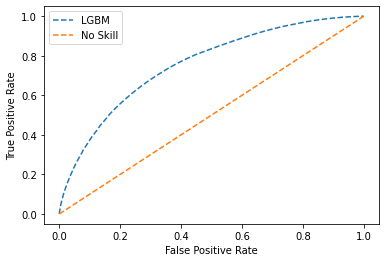

In [211]:
fpr, tpr, thresholds = roc_curve(y_test, [item for item in pred])
auc = roc_auc_score(y_test, y_pred)
pyplot.plot(fpr, tpr, linestyle='--', label='LGBM')
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Precision and Recall
- Para explicarlo con palabras propias interpretando los resultados
    * Precision: Indica que acertamos el 68% de los que se predicen como usuarios que clasificaran Alta la película.
    * Recall: Determina que detectamos el 71% de las clasificaciones altas que realizan los usuarios a las películas.
    * Accuracy: El 69% de las clasificaciones altas o bajas son predichas correctamente

In [212]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.69      0.69   3016823
           1       0.68      0.70      0.69   2919537

    accuracy                           0.69   5936360
   macro avg       0.69      0.69      0.69   5936360
weighted avg       0.69      0.69      0.69   5936360



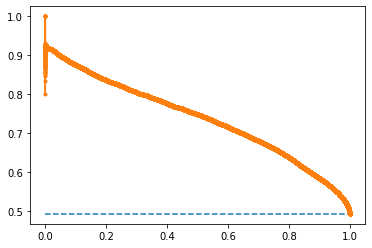

In [213]:
from sklearn.metrics import precision_recall_curve
lr_precision, lr_recall, _ = precision_recall_curve(y_test, pred)
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')

### Matriz de Confusion

    - Se observa un 69% de accuracy y un 16% de falsos positivos

<AxesSubplot:>

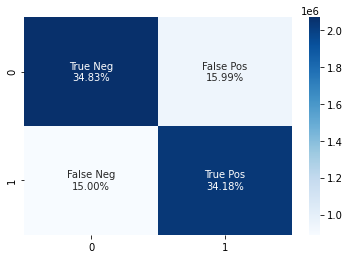

In [214]:
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

### Feature Importance
- El algoritmo no solo tiene soluciones propias para determinal la importancia de variables, sino que ademas nos permite profundizar y aplicar Shap-values para analizar el impacto de las variables.

    - Las variables generadas en torno al rating de las peliculas y de los usuario generada desde el train set, fueron las variables con mayor importancia predictiva. 
    - Dentro del top five se encuentra el promedio movil del usuario de acuerdo a la fecha del rating y cuantas pelicas puntuó el usuario.
    - Destacamos dentro del top 10, el rating de la película anterior del usuario, cuantas pelicas puntuó , la popularidad de la pelicula y el año del film.
    - El One-Hot Encoder del genero no genero gran relevancia, pero si el año de la película.
    - Esto demuestra que tenemos oportunidad para explorar como incluimos el genero dentro del dataset.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

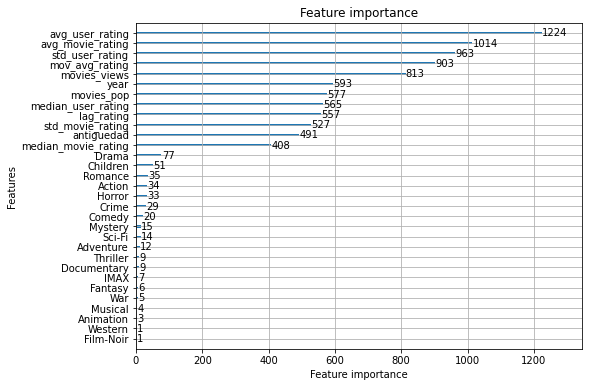

In [215]:
lgb.plot_importance(gbm, figsize=(8,6))

#### SHAP values
    - Podemos observar como contribuyen a la predicción y si impacta mas en los positivos o negativos. Por ejemplo el promedio del rating de la pelicula parece contribuir igualmente para ambos valores del targen biinario, en cambio el promedio movil impacta en mayor medida en los positivos.
    
    - Aclaracion Importante: Corri shape values con una muestra de 5000 del test, ya que su procesamiento es elevado y demora tiempo computacional.

In [216]:
pred_shape = np.zeros((5000,32))
for fold_id in range(n_folds):
    gbm_a = lgb.Booster(model_file='model/lightgbm_model_%d.txt' % fold_id)
    current_pred = gbm_a.predict(X_test_proc[:5000], pred_contrib=True)
    pred_shape += current_pred
pred_shape /= n_folds

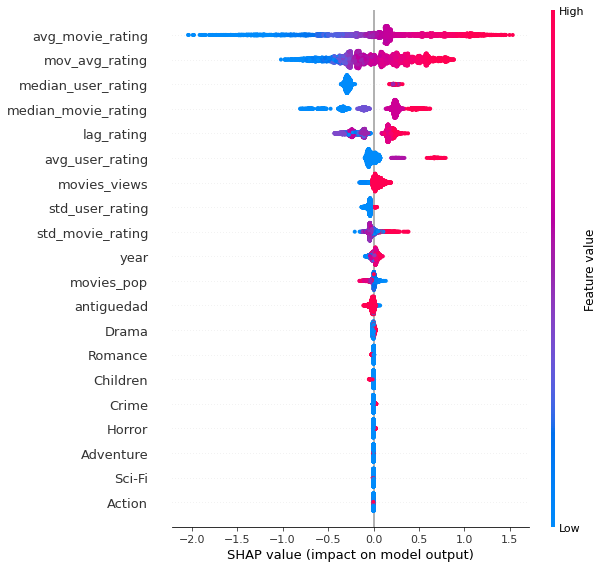

In [217]:
#explainer = shap.TreeExplainer(gbm)
#shap_values = explainer.shap_values(X_test.iloc[:50000])
shap.summary_plot(pred_shape[:,:-1], X_test.iloc[:5000])

* Podemos observar por variable generada, en este caso el promedio movil del rating, como a medida que incrementa como aumenta su impacto en el target positivo. Es decir los clientes con un promedio movil alto hay altas probabilidades que puntue alto a la pelicula.

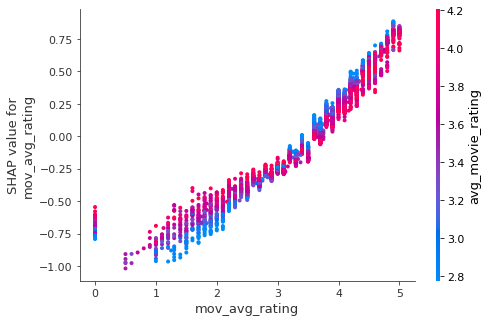

In [218]:
shap.dependence_plot("mov_avg_rating", pred_shape[:,:-1], X_test.iloc[:5000])

- Por el contrario parece que la variable del rating anterior, si un cliente puntua bajo una pelicula es mas probable que la proxima pelicula sea puntada bajo.

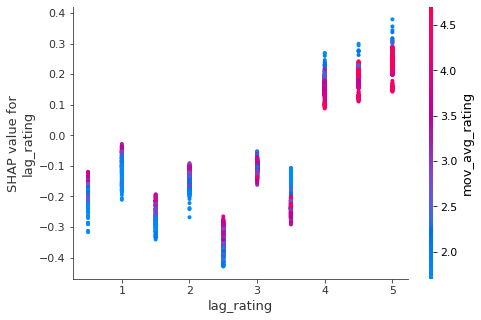

In [219]:
shap.dependence_plot("lag_rating", pred_shape[:,:-1], X_test.iloc[:5000])

### Conclusiones Finales

- realmente me parecio un desafio interesante, parece simple pero al momento de pensarlo hay varias formas de encararlo. Me hubiese gustado generar mas features las que mencione en la notebook anterior, ya que veo que tiene potencial predictivo de acuerdo a las variables que observo en el feature importance.
- Obviamente hay mas posibilidades de mejora en la predicción del modelo, empezando por explorar otros algoritmos, selección de variables, realizar ajuste de hiperparámetros.
- Gracias por la posibilidad y espero que haber sido claro con la explicación, la metodología seleccionada y el orden del código.